In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.animation as animation

from torch.utils.data import Dataset
import binvox
import os
import json
import trimesh
import skimage
import random
from mesh_to_sdf import mesh_to_voxels, sample_sdf_near_surface, scale_to_unit_sphere
import mesh_to_sdf
import pyrender
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import io
from deep_sdf import utils, metrics, plotting
import math
import pandas as pd


import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

ModuleNotFoundError: No module named 'deep_sdf'

In [5]:
plane_gt = "/mnt/hdd/ShapeNetCore.v2/02691156/12c82319147385e7ef0e1705c5c9e361/models/model_normalized.obj"
plane_recon = "examples/plane_ours/TensorBoard/ReconstructionsTrain/02691156_12c82319147385e7ef0e1705c5c9e361/train_mesh_epoch=2020.ply"
plane_recon = "examples/plane_ours/TensorBoard/ReconstructionsTrain/02691156_12c82319147385e7ef0e1705c5c9e361/train_mesh_epoch=120.ply"

In [6]:
gt_mesh = utils.as_mesh(trimesh.load_mesh(plane_gt))
recon_mesh = utils.as_mesh(trimesh.load_mesh(plane_recon))

In [7]:
metrics.compute_metric(gt_mesh, recon_mesh)

0.07700319746289094

In [15]:
metrics.compute_metric(trimesh.load_mesh(plane_gt), trimesh.load_mesh(plane_recon))


AttributeError: 'Scene' object has no attribute 'area_faces'

In [2]:
metrics.compute_metric(trimesh.load_mesh(plane_gt), trimesh.load_mesh(plane_recon))


NameError: name 'plane_gt' is not defined

In [4]:
for epoch in [200, 400, 600, 800, 1000]:
    print("EPOCH: ", epoch)
    get_recon_path = lambda class_id, shape_id: f"/home/shared/deepsdfcomp/searches/ffe_100_shapes/exp_0011_CodeLength=60_encoding_features=23_encoding_sigma=0.783/TensorBoard/ReconstructionsTrain/{class_id}_{shape_id}/epoch={epoch}.ply"
    get_gt_path = lambda class_id, shape_id: f"/mnt/hdd/ShapeNetCore.v2/{class_id}/{shape_id}/models/model_normalized.obj"

    reconstr_dirs = os.listdir("/home/shared/deepsdfcomp/searches/ffe_100_shapes/exp_0011_CodeLength=60_encoding_features=23_encoding_sigma=0.783/TensorBoard/ReconstructionsTrain")
    shapes = [dir_name.split("_") for dir_name in reconstr_dirs]

    cds = []
    for (class_id, shape_id) in shapes:
        gt_path = get_gt_path(class_id, shape_id)
        gt_mesh = utils.as_mesh(trimesh.load_mesh(gt_path))
        recon_path = get_recon_path(class_id, shape_id)
        recon_mesh = utils.as_mesh(trimesh.load_mesh(recon_path))
        cd = metrics.compute_metric(gt_mesh, recon_mesh, num_mesh_samples=30000)
        print(f"Shape {shape_id} from class {class_id} with CD={cd:.3f}")
        cds.append(cd)
    print(f"Avg CD={sum(cds)/len(cds):.4f}")

EPOCH:  200


TypeError: unsupported format string passed to tuple.__format__

In [5]:
gt_mesh = utils.as_mesh(trimesh.load_mesh(plane_gt))
recon_mesh = utils.as_mesh(trimesh.load_mesh(plane_recon))

[['02691156', '122963149f6a04272620819ddac40644'],
 ['02691156', '124062ccaeae95085e9e2656aff7dd5b'],
 ['02691156', '1628b65a9f3cd7c05e9e2656aff7dd5b'],
 ['02691156', '144070f63941362bd1810447902e2904'],
 ['02691156', '10cfc2090a2ade124c3a35cee92bb95b']]

In [3]:
metrics.compute_metric(gt_mesh, gt_mesh, num_mesh_samples=30000)

5.876217082101655e-06

In [5]:
cd, all_dists = metrics.compute_metric(recon_mesh, recon_mesh, num_mesh_samples=30000)

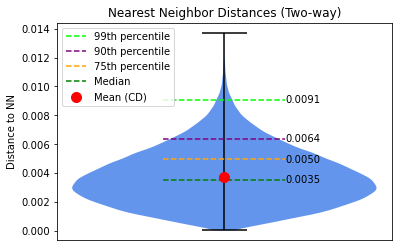

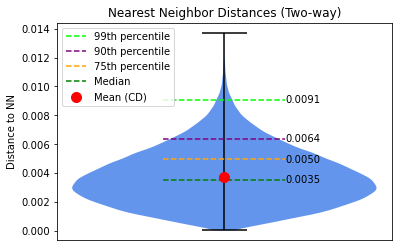

In [27]:
plotting.plot_dist_violin(all_dists)

In [16]:
print("Box")

box1 = trimesh.primitives.Box(extents=[1, 1, 1])
box2 = trimesh.primitives.Box(extents=[1, 1, 2])

num_mesh_samples = 60000
cd1, _ = metrics.compute_metric(box1, box1, num_mesh_samples=num_mesh_samples)
print("CD1: ", cd1)

num_mesh_samples_per_side = num_mesh_samples / 6
cd12_expected = 0 + (2 * num_mesh_samples_per_side * 0.5) / num_mesh_samples
cd12_expected *= 2      # two-way
print("CD12 expected: ", cd12_expected)

cd12, _ = metrics.compute_metric(box1, box2, num_mesh_samples=num_mesh_samples)
print("CD12: ", cd12)

Box
CD1:  6.345233230725315e-05
CD12 expected:  0.3333333333333333
CD12:  0.09682890734703407


In [15]:
print("Sphere")

sphere1 = trimesh.primitives.Sphere(radius=1)
sphere2 = trimesh.primitives.Sphere(radius=2)

num_mesh_samples = 60000
cd1, _ = metrics.compute_metric(sphere1, sphere1, num_mesh_samples=num_mesh_samples)
print("CD1: ", cd1)

cd12_expected = num_mesh_samples * 1 / num_mesh_samples
cd12_expected *= 2      # two-way
print("CD12 expected: ", cd12_expected)

cd12, _ = metrics.compute_metric(sphere1, sphere2, num_mesh_samples=num_mesh_samples)
print("CD12: ", cd12)

Sphere
CD1:  0.0001330898998968488
CD12 expected:  2.0
CD12:  1.9860454532156915


In [2]:
print("Cylinder")

cylinder1 = trimesh.primitives.Cylinder(radius=1, height=1)
cylinder2 = trimesh.primitives.Cylinder(radius=2, height=1)

num_mesh_samples = 60000
cd1, _ = metrics.compute_metric(cylinder1, cylinder1, num_mesh_samples=num_mesh_samples)
print("CD1: ", cd1)

get_side_surf_samples_frac = lambda r,h: (2*math.pi*r*h) / (2*math.pi*(r**2) + 2*math.pi*r*h)
# slight overapprox, since I neglect the "overhangs" at the top and bottom surfaces
cd12_expected = get_side_surf_samples_frac(1, 1) * num_mesh_samples * 1. / num_mesh_samples
cd12_expected *= 2      # two-way
print("CD12 expected: ", cd12_expected)

cd12, _ = metrics.compute_metric(cylinder1, cylinder2, num_mesh_samples=num_mesh_samples)
print("CD12: ", cd12)

Cylinder
CD1:  0.00013185724826310404
CD12 expected:  1.0
CD12:  0.5632856379423922


In [1]:
import pandas as pd
import ast

df = pd.read_csv("examples/planes/Evaluation/2000/chamfer.csv", delimiter=";")
df.head()
df.mean()

/tmp/ipykernel_2151013/2272287560.py:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.mean()


chamfer_dist    0.000146
dtype: float64

In [16]:
df.iloc[11]

dims                 [256, 256, 256, 256, 256, 256, 256, 256]
dropout                                                    []
dropout_prob                                              0.0
norm_layers                                                []
latent_in                                                 [0]
xyz_in_all                                                1.0
latent_dropout                                            0.0
weight_norm                                               1.0
nonlinearity                                             sine
encoding_features                                         1.0
encoding_sigma                                            0.0
BestTrainLoss                                        0.020659
BestTrainCD                                              -1.0
BestTestCD                                               -1.0
Name: 11, dtype: object

In [2]:
def plot_binary_vs_continuous(df, binary: str, continuous: str):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    df.plot(x=binary, y=continuous, kind="bar", ax=ax[0])
    df.groupby(binary).apply(lambda g: g.mean()).plot(y=continuous, kind="bar", ax=ax[1])

df = pd.read_csv("hparams_table.csv")
df_smaller_lr = df[df["BestTrainLoss"] < 0.026]
df_smaller_lr.iloc[df_smaller_lr["BestTrainLoss"].argmin()]

dims                 [256, 256, 256, 256, 256, 256, 256, 256]
dropout                                                    []
dropout_prob                                              0.0
norm_layers                                                []
latent_in                                              [4, 0]
xyz_in_all                                                1.0
latent_dropout                                            1.0
weight_norm                                               1.0
nonlinearity                                             sine
encoding_features                                         1.0
encoding_sigma                                            0.0
BestTrainLoss                                        0.006735
BestTrainCD                                              -1.0
BestTestCD                                               -1.0
Name: 18, dtype: object

/tmp/ipykernel_2607707/719333149.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.groupby(binary).apply(lambda g: g.mean()).plot(y=continuous, kind="bar", ax=ax[1])


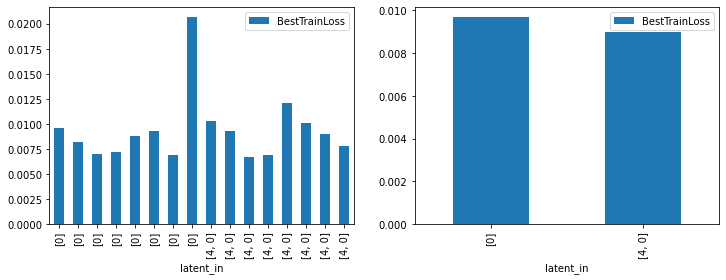

In [8]:
plot_binary_vs_continuous(df_smaller_lr, "latent_in", "BestTrainLoss")

/tmp/ipykernel_2607707/719333149.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.groupby(binary).apply(lambda g: g.mean()).plot(y=continuous, kind="bar", ax=ax[1])


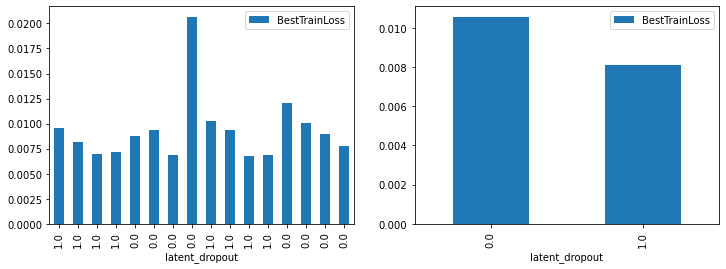

In [10]:
plot_binary_vs_continuous(df_smaller_lr, "latent_dropout", "BestTrainLoss")

In [ ]:
plot_binary_vs_continuous("latent_in", "BestTrainLoss")

/tmp/ipykernel_1613479/684658670.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.groupby("latent_dropout").apply(lambda g: g.mean()).plot(y="BestTrainLoss", kind="bar", ax=ax[1])


<AxesSubplot:xlabel='latent_dropout'>

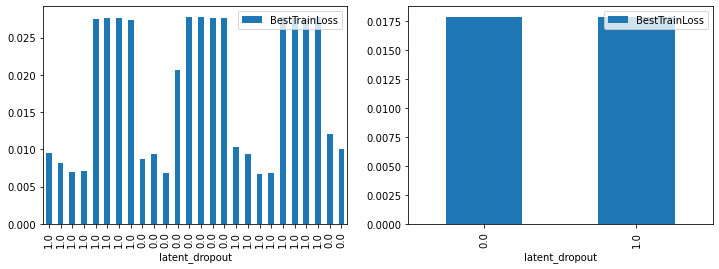

In [5]:
mesh = trimesh.load("../../quadriflow.obj")

In [6]:
mesh.faces.shape

(1404, 3)

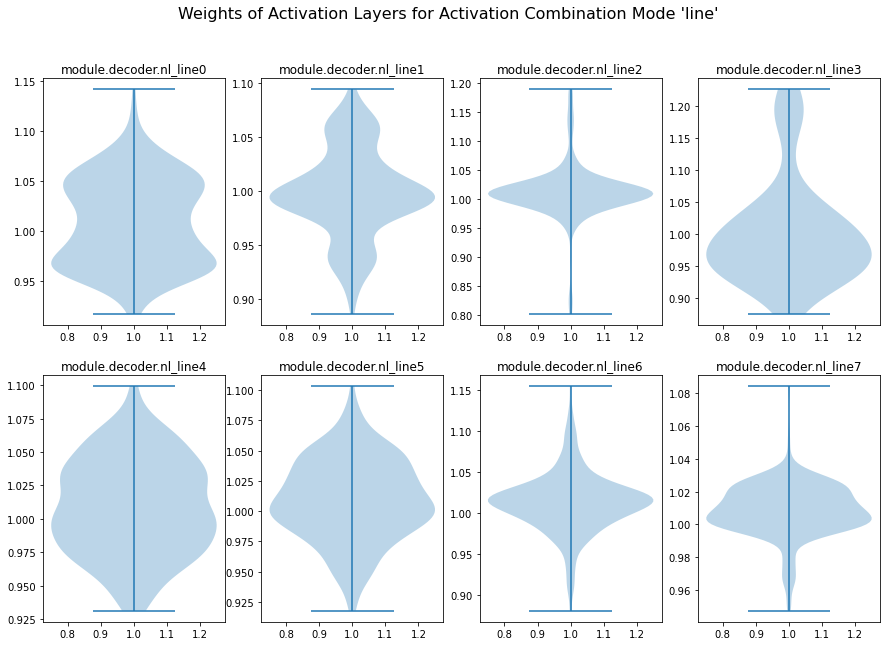

In [32]:
import torch
from matplotlib import pyplot as plt
chckpt = torch.load("/home/shared/deepsdfcomp/searches/double_nonlinearity/line/ModelParameters/latest.pth")
fig, axes = plt.subplots(2, 4, figsize=(15,10))
fig.suptitle("Weights of Activation Layers for Activation Combination Mode 'line'", fontsize=16)
for i, (k,v) in enumerate([(kk, vv) for kk, vv in chckpt["model_state_dict"].items() if "nl_line" in kk][:8]):
    ax = axes[i//4,i%4]
    ax.set_title(k)
    vplot = ax.violinplot(v.detach().cpu().numpy(), showmeans=False, showextrema=True)
plt.show()

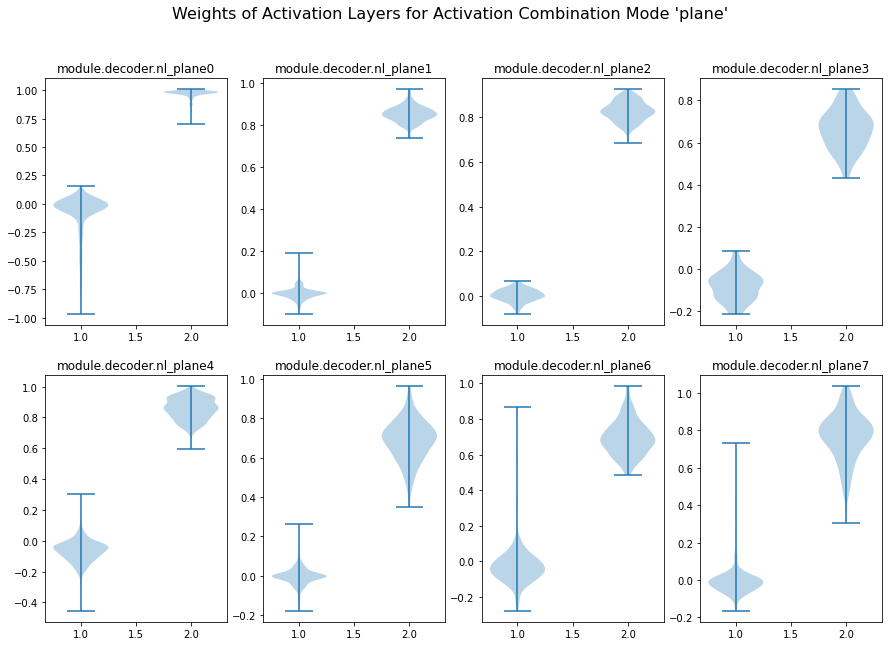

In [39]:
import torch
from matplotlib import pyplot as plt
chckpt = torch.load("/home/shared/deepsdfcomp/searches/double_nonlinearity/plane/ModelParameters/latest.pth")
fig, axes = plt.subplots(2, 4, figsize=(15,10))
fig.suptitle("Weights of Activation Layers for Activation Combination Mode 'plane'", fontsize=16)
for i, (k,v) in enumerate([(kk, vv) for kk, vv in chckpt["model_state_dict"].items() if "nl_plane" in kk][:8]):
    ax = axes[i//4,i%4]
    ax.set_title(k)
    vplot = ax.violinplot(v.detach().cpu().numpy(), showmeans=False, showextrema=True)
plt.show()

In [1]:
import pandas as pd
data = pd.read_csv("/home/shared/deepsdfcomp/searches/double_nonlinearity/siren_latentsize=150_width=256/Evaluation/2000/chamfer.csv", delimiter=';')
print(f"{data['chamfer_dist'].mean():5f}, {data['chamfer_dist'].median():5f}")

0.000186, 0.000037


In [ ]:
python reconstruct.py -e ../../shared/deepsdfcomp/searches/double_nonlinearity/line --split ../../shared/deepsdfcomp/experiments/splits/sv2_planes_test.json -d ../../shared/deepsdfcomp/data/ --skip